In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from lightning.evaluation import *
import pickle
import os
import numpy as np
import scipy.stats as stats

/tmp/ipykernel_21687/4162430608.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [2]:
comments = {
'imOXXb' : ('CrFiqaNet-iresnet18-CrFiqaLoss-imOXXb'              , 'Trained well, gives results, certainty ratio'),
'GzGNXb' : ('CrFiqaNet-iresnet50-CrFiqaLoss-GzGNXb'              , 'Trained well, gives results, certainty ratio'),
'H1SWXb' : ('CrFiqaNet-magiresnet18-CrFiqaLoss-H1SWXb'           , 'Did not train, loss to high number'),
'0IRWXb' : ('CrFiqaNet-mobilenetv3_large-CrFiqaLoss-0IRWXb'      , 'Trained well, certainty ratio'),
'0G8VXb' : ('DfsNet-0G8VXb'                                      , 'Refernce with 640x480 input'),
'hdpNXb' : ('DfsNet-hdpNXb'                                      , 'Reference with 224x244 input'),
'3wDNXb' : ('PfeNet-iresnet50-3wDNXb'                            , 'PFE with ArcFace'),
'RyENXb' : ('PfeNet-iresnet50-RyENXb'                            , 'PFE with MagFace'),
'YuBXXb' : ('RecognitionNet-iresnet18-MagFaceLoss-YuBXXb'        , 'iResNet18, crop, without fully connected layer'),
'0g9LXb' : ('RecognitionNet-iresnet50-ArcFaceLoss-0g9LXb'        , 'Unwrap baseline with ArcFace, without fully connected layer'),
'UVyKXb' : ('RecognitionNet-iresnet50-ArcFaceLoss-UVyKXb'        , 'Crop baseline with ArcFace, without fully connected layer'),
'DaqKXb' : ('RecognitionNet-iresnet50-MagFaceLoss-DaqKXb'        , 'Crop baseline with MagFace, without fully connected layer'),
'ciWLXb' : ('RecognitionNet-iresnet50-MagFaceLoss-ciWLXb'        , 'Unwrap baseline with MagFace, without fully connected layer'),
'7B0TXb' : ('RecognitionNet-magiresnet18-MagFaceLoss-7B0TXb'     , 'Showcase of wrong schedule settings'),
'xjxTXb' : ('RecognitionNet-magiresnet18-MagFaceLoss-xjxTXb'     , 'Showcase of good schedule setting'),
'RMdMXb' : ('RecognitionNet-magiresnet50-ArcFaceLoss-RMdMXb'     , 'Unwraped ArcFace'),
'arzKXb' : ('RecognitionNet-magiresnet50-ArcFaceLoss-arzKXb'     , 'Croped ArcFace'),
'931RXb' : ('RecognitionNet-magiresnet50-MagFaceLoss-931RXb'     , 'No augment'),
'JnGKXb' : ('RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb'     , 'Crop baseline'),
'ihfMXb' : ('RecognitionNet-magiresnet50-MagFaceLoss-ihfMXb'     , 'Unwrap baseline'),
'vfFRXb' : ('RecognitionNet-magiresnet50-MagFaceLoss-vfFRXb'     , 'Shear + translate'),
'PUXTXb' : ('RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb', 'Small MobileNetV3, baseline crop, without fully connected layer'),
'BnkOXb' : ('SddFiqaNet-iresnet50-BnkOXb'                        , 'SDDFIQA with labels from JnGKXb, with labels from iResNet50 crop without fc'),
'UeIWXb' : ('SddFiqaNet-iresnet50-UeIWXb'                        , 'SDDFIQA with labels from PUXTXb, with labels fomr MobileNetV3'),
'UnMWXb' : ('SddFiqaNet-iresnet50-UnMWXb'                        , 'SDDFIQA with labels from 7B0TXb, wrong magiresenet18'),
'e9KWXb' : ('SddFiqaNet-iresnet50-e9KWXb'                        , 'SDDFIQA with labels from xjxTXb, small magiresnet18'),
'wJJWXb' : ('SddFiqaNet-iresnet50-wJJWXb'                        , 'SDDFIQA with labels from GOTTXb, untrained mobilenetv3'),
'wyQXXb' : ('SddFiqaNet-iresnet50-wyQXXb'                        , 'SDDFIQA with labels from YuBXXb, small withou fc'),
}

In [49]:
with open('scores.pickle', 'rb') as f:
    scores = pickle.load(f)
with open('qualities.pickle', 'rb') as f:
    qualities = pickle.load(f)
with open('datasets.pickle', 'rb') as f:
    datasets = pickle.load(f)
datasets_names = {
    'iris_verification_NDCSI2013_01_05': 'Univesity of Notre Dame 2013',
    'iris_verification_nd_0405_01_01': 'Univesity of Notre Dame 0405',
    'iris_verification_inno_keymaker_01_01': 'Innovatrics',
    'iris_verification_iitd_01_01': 'IITD',
}

In [65]:
CM_TO_INCH = 1.0/2.5
def matplotlib_plot_det(fmr, fnmr, ax, label="", fontsize=12, fontname='DejaVu Sans'):
    x = np.array(stats.norm.ppf(fmr))
    y = np.array(stats.norm.ppf(fnmr))
    ax.plot(x, y, label=label)
    ticks = [0.001,0.004,0.01, 0.023, 0.05, 0.1, 0.20, 0.35, 0.5, 0.80, 0.95, 0.99, 0.999]
    tick_locations = stats.norm.ppf(ticks)
    tick_labels = [
        "{:.0%}".format(s) if (100 * s).is_integer() else "{:.1%}".format(s)
        for s in ticks
    ]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=fontsize, fontname=fontname)
    ax.set_xlim(-3.5, 0)
    ax.set_yticks(tick_locations)
    ax.set_yticklabels(tick_labels, fontsize=fontsize, fontname=fontname)
    ax.set_ylim(-3.5, 0)

def plot_scores(scores_selector_dict, fontsize=12, offset_legend=0.11, ncol=2):
    global scores, datasets, datasets_names
    fontname='DejaVu Serif'
    fig, axs = plt.subplots(2, 2, figsize=(CM_TO_INCH*15, 12*CM_TO_INCH), sharex=True, sharey=True)
    axs = axs.flatten()
    axs_dict = dict(zip(datasets.keys(), axs))
    print(axs_dict)
    for run, label in scores_selector_dict.items():
        run_name = comments[run][0]
        run_comment = comments[run][1]
        print(run_name, ':', run_comment)
        for dataset in datasets:
            labels, sc, pairs = generate_labels_scores(scores[dataset+'+'+run]['pairs'], scores[dataset+'+'+run]['impostors'])
            sc=-sc
            fmr, fnmr, treashold = det_curve(labels, sc)
            matplotlib_plot_det(fmr=fmr, fnmr=fnmr, ax=axs_dict[dataset], label=label, fontsize=fontsize, fontname=fontname)
    for dataset, ax in axs_dict.items():
        ax.set_title(datasets_names[dataset], fontsize=fontsize, fontname=fontname)
        ax.grid(True)
    axs[2].set_xlabel('FMR',fontsize=fontsize, fontname=fontname)
    axs[3].set_xlabel('FMR',fontsize=fontsize, fontname=fontname)
    axs[0].set_ylabel('FNMR',fontsize=fontsize, fontname=fontname)
    axs[2].set_ylabel('FNMR',fontsize=fontsize, fontname=fontname)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend*2)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig


{'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>, 'iris_verification_NDCSI2013_01_05': <AxesSubplot:>}
RecognitionNet-iresnet50-ArcFaceLoss-UVyKXb : Crop baseline with ArcFace, without fully connected layer
RecognitionNet-iresnet50-MagFaceLoss-DaqKXb : Crop baseline with MagFace, without fully connected layer
RecognitionNet-magiresnet50-ArcFaceLoss-arzKXb : Croped ArcFace
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline


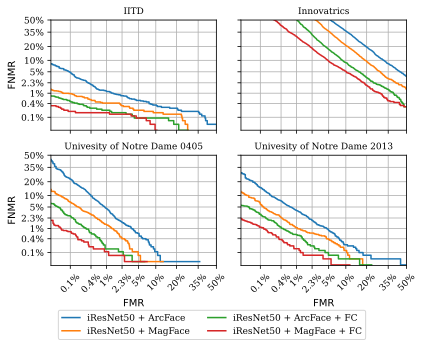

In [66]:
fig = plot_scores({
'UVyKXb' : 'iResNet50 + ArcFace',
'DaqKXb' : 'iResNet50 + MagFace',
'arzKXb' : 'iResNet50 + ArcFace + FC',
'JnGKXb' : 'iResNet50 + MagFace + FC',
}, fontsize=9)
fig.savefig('plots/arcface_vs_magface.pdf')

{'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>, 'iris_verification_NDCSI2013_01_05': <AxesSubplot:>}
RecognitionNet-magiresnet50-ArcFaceLoss-arzKXb : Croped ArcFace
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
RecognitionNet-magiresnet50-ArcFaceLoss-RMdMXb : Unwraped ArcFace
RecognitionNet-magiresnet50-MagFaceLoss-ihfMXb : Unwrap baseline


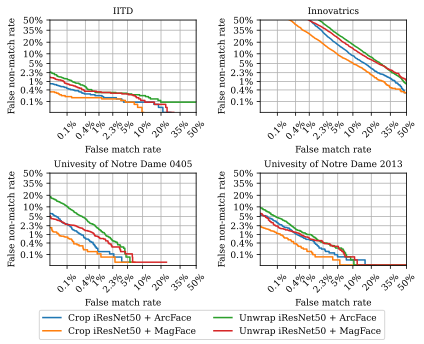

In [6]:
fig = plot_scores({
'arzKXb' : 'Crop iResNet50 + ArcFace',
'JnGKXb' : 'Crop iResNet50 + MagFace',
'RMdMXb' : 'Unwrap iResNet50 + ArcFace',
'ihfMXb' : 'Unwrap iResNet50 + MagFace',
}, fontsize=9, ncol=2, offset_legend=0.11)
fig.savefig('plots/crop_vs_unwrap.pdf')

{'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>, 'iris_verification_NDCSI2013_01_05': <AxesSubplot:>}
RecognitionNet-iresnet50-MagFaceLoss-DaqKXb : Crop baseline with MagFace, without fully connected layer
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
RecognitionNet-iresnet18-MagFaceLoss-YuBXXb : iResNet18, crop, without fully connected layer
RecognitionNet-magiresnet18-MagFaceLoss-xjxTXb : Showcase of good schedule setting
RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb : Small MobileNetV3, baseline crop, without fully connected layer


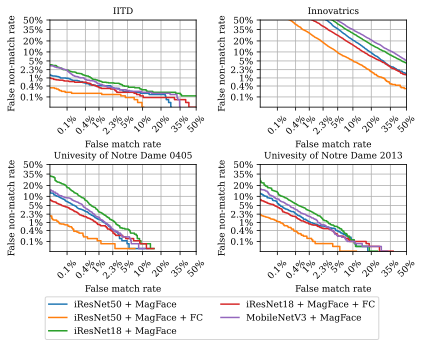

In [7]:
fig = plot_scores({
'DaqKXb' : 'iResNet50 + MagFace',
'JnGKXb' : 'iResNet50 + MagFace + FC',
'YuBXXb' : 'iResNet18 + MagFace',
'xjxTXb' : 'iResNet18 + MagFace + FC',
'PUXTXb' : 'MobileNetV3 + MagFace',
}, fontsize=9, offset_legend=0.13)
fig.savefig('plots/small_vs_large.pdf')

{'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>, 'iris_verification_NDCSI2013_01_05': <AxesSubplot:>}
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
RecognitionNet-magiresnet50-MagFaceLoss-931RXb : No augment
RecognitionNet-magiresnet50-MagFaceLoss-vfFRXb : Shear + translate


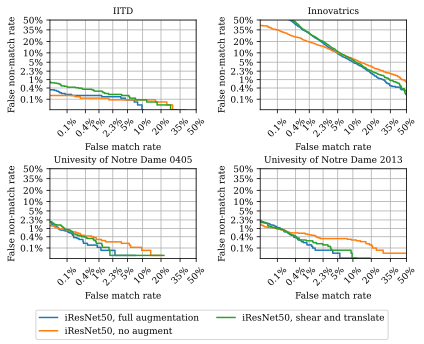

In [8]:
fig = plot_scores({
'JnGKXb' : 'iResNet50, full augmentation',
'931RXb' : 'iResNet50, no augment',
'vfFRXb' : 'iResNet50, shear and translate',
}, fontsize=9, offset_legend=0.12, ncol=2)
fig.savefig('plots/augment_vs_no_augment.pdf')

In [57]:
def plot_irrs(baseline_run, scores_selector_dict, dataset_fmr_dict, fontsize=12, offset_legend=0.11, fontname='DejaVu Serif', ncol=2):
    global qualities, scores, datasets, datasets_names
    fig, axs = plt.subplots(4, 1, figsize=(CM_TO_INCH*15, 25*CM_TO_INCH))
    axs = axs.flatten()
    axs_dict = dict(zip(datasets.keys(), axs))
    print(axs_dict)
    
    for run, label in scores_selector_dict.items():
        run_name = comments[run.split('+')[0]][0]
        run_comment = comments[run.split('+')[0]][1]
        print(run_name, ':', run_comment)
        for dataset in datasets:
            labels_sorted, sc_sorted, quality_scores = generate_sorted_labels_scores_quality(scores[dataset+'+'+baseline_run]['pairs'], scores[dataset+'+'+baseline_run]['impostors'], qualities[dataset+'+'+run])
            sc_sorted=-sc_sorted
            irr, fnmr = fnmr_at_irr(labels_sorted, sc_sorted, max_reject_rate=0.2, fmr_anchor=dataset_fmr_dict[dataset])
            #irr, fnmr = eer_at_irr(labels_sorted, sc_sorted, max_reject_rate=0.2)
            axs_dict[dataset].plot(irr, fnmr, label=label)
    for dataset, ax in axs_dict.items():
        ax.set_xlabel('Input reject rate', fontsize=fontsize, fontname=fontname)
        ax.set_ylabel('FNMR', fontsize=fontsize, fontname=fontname)
        ax.set_title(datasets_names[dataset] + f' FMR={dataset_fmr_dict[dataset]*100:.2}%', fontsize=fontsize, fontname=fontname)
        ax.grid(True)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend*2)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig

{'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>, 'iris_verification_NDCSI2013_01_05': <AxesSubplot:>}
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
CrFiqaNet-iresnet50-CrFiqaLoss-GzGNXb : Trained well, gives results, certainty ratio
SddFiqaNet-iresnet50-BnkOXb : SDDFIQA with labels from DaqKXb, with labels from iResNet50 crop without fc


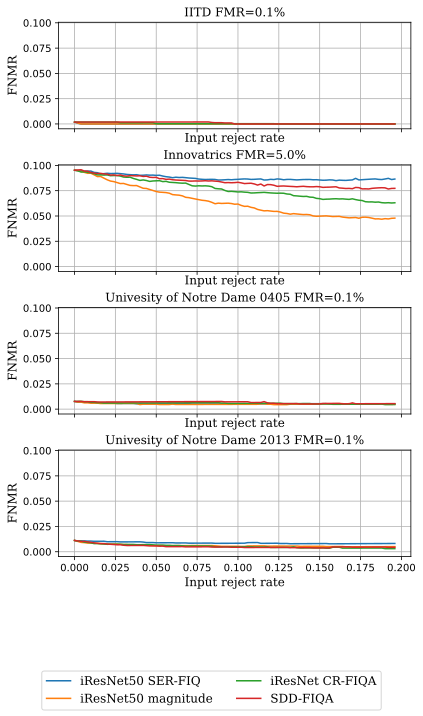

In [58]:
fig =  plot_irrs('JnGKXb', {
    'JnGKXb+serfiq' : 'iResNet50 SER-FIQ',
    'JnGKXb+magnitude' : 'iResNet50 magnitude',
    'GzGNXb' : 'iResNet CR-FIQA',
    'BnkOXb' : 'SDD-FIQA'
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.05,
    'iris_verification_iitd_01_01': 0.001,
}
)